## Analysis of a ribosome profiling data using a transcriptome assembly as a reference

This analysis includes a highly phased ribosome profiling data for _Salmonella enterica_ serovar Typhimurium (PRJEB51486) and PacBio long-read and Illumina short-read data for transcriptome assembly (PRJEB6002)

### On a local machine to use Docker

#### Download PacBio long-read RNA-seq data (strain D23005)

```
mkdir -p ~/Documents/manuscript/riboss ~/Documents/manuscript/riboss/styphimurium

cd ~/Documents/manuscript/riboss/styphimurium

wget "https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJEB6002&result=read_run&fields=study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_model,library_layout,library_strategy,library_source,fastq_ftp,submitted_ftp,sra_ftp,sample_alias,sample_title,bam_ftp&format=tsv&download=true&limit=0" -O filereport_read_run_PRJEB6002_tsv.txt

awk 'BEGIN{FS="\t"} /m140726_040902|m140801_073558|m140814_095222/ {print $13}' \
    filereport_read_run_PRJEB6002_tsv.txt \
    | tr ';' '\n' \
    | awk '{print "wget -nc ftp://" $1}' | sh
```

#### Download and run a Docker image for SMRT-analysis 2.3.0

```
sudo docker pull jyang88/smrtanalysis2.3.0:latest

sudo docker run -it -v /home/chunlim/Documents:/data jyang88/smrtanalysis2.3.0:latest bash

/opt/smrtanalysis/current/smrtcmds/bin/smrtshell

cd data/manuscript/riboss/styphimurium
```

#### Create files of file names for SMRT-analysis

```
ls m140726_040902* > m140726_040902.fofn
ls m140801_073558* > m140801_073558.fofn
ls m140814_095222* > m140814_095222.fofn
```

#### Construct CCS reads

```
for i in \*.fofn; do \
    ConsensusTools.sh CircularConsensus \
    --minFullPasses 0 --minPredictedAccuracy 75 \
    --parameters /opt/smrtanalysis/install/smrtanalysis_2.3.0.140936/analysis/etc/algorithm_parameters/2014-09/ \
    --numThreads 32 --fofn $i \
    -o output
done

cp output/*.fastq

gzip *.fastq
```

#### Exit docker image and scp the the CCS fastq files to a server to continue the analysis

### On a server

#### Download ribosome profiling and RNA-seq data (strain LT2)

```
mkdir -p /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq

cd /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq

wget "https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJEB51486&result=read_run&fields=study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_model,library_layout,library_strategy,library_source,fastq_ftp,submitted_ftp,sra_ftp,sample_alias,sample_title,bam_ftp&format=tsv&download=true&limit=0" -O filereport_read_run_PRJEB51486_tsv.txt

awk 'BEGIN{FS="\t"} NR>1 {print "wget -nc ftp://" $12}' filereport_read_run_PRJEB51486_tsv.txt | sh
```

#### Download Illumina short-read RNA-seq alignment files (strain D23005)

```
mkdir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/illumina

cd /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/illumina

awk 'BEGIN{FS="\t"} /14256_2#2|14256_2#8|14256_2#14|14256_2#5|14256_2#11|14256_2#17|13851_1#14|13851_1#13|13851_1#15/ {print $13}' \
    filereport_read_run_PRJEB6002_tsv.txt \
    | tr ';' '\n' \
    | awk '{print "wget -nc ftp://" $1}' | sh

#### Install samtools (for handling CRAM quickly, [not](https://github.com/samtools/htslib/issues/605) a recommended installation method)

```
git clone https://github.com/samtools/samtools.git
cd samtools
SAMTOOLSDIR=$PWD
# git checkout eb0992ff8a99b895364a7a861b418a1beb77d540

wget https://github.com/samtools/htslib/releases/download/1.21/htslib-1.21.tar.bz2
tar jxvf htslib-1.21.tar.bz2
cd htslib-1.21
./configure --enable-libcurl --prefix=$PWD
make
cd ..

./configure --enable-plugins --enable-libcurl --with-htslib=$PWD/htslib-1.21
make all all-htslib
```

#### Merge CRAM files

```
$SAMTOOLSDIR/samtools merge \
    14256_2\#2.cram 14256_2\#8.cram 14256_2\#14.cram \
    14256_2\#5.cram 14256_2\#11.cram 14256_2\#17.cram \
    13851_1\#14.cram 13851_1\#13.cram 13851_1\#15.cram \
    -o D23005.cram

samtools sort D23005.cram -O BAM -o ../D23005.sorted.bam

rm D23005.cram
```

#### Download the LT2 reference genome for transcriptome_assembly

```
mkdir -p /home/limch05p/lim_group/riboss /home/limch05p/lim_group/riboss/ref

cd /home/limch05p/lim_group/riboss/ref

wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.1_ASM694v1/GCF_000006945.1_ASM694v1_genomic.fna.gz

zcat GCF_000006945.1_ASM694v1_genomic.fna.gz \
    | sed 's/NC_003197.1/gi|16763390|ref|NC_003197.1|/' \
    > /home/limch05p/lim_group/riboss/ref/NC_003197.1.fasta
```

#### Download and convert GFF3 to BED and GTF for operon_finder

```
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.1_ASM694v1/GCF_000006945.1_ASM694v1_genomic.gff.gz

zcat /home/limch05p/lim_group/riboss/ref/GCF_000006945.1_ASM694v1_genomic.gff.gz \
    | gff3ToGenePred stdin stdout \
    | genePredToBed stdin stdout \
    | awk '/NC_003197.1/ && sub("NC_003197.1","gi|16763390|ref|NC_003197.1|")' \
    > /home/limch05p/lim_group/riboss/ref/NC_003197.1.bed

zcat /home/limch05p/lim_group/riboss/ref/GCF_000006945.1_ASM694v1_genomic.gff.gz \
    | gff3ToGenePred stdin stdout \
    | genePredToGtf file stdin stdout \
    | awk '/NC_003197.1/ && sub("NC_003197.1","gi|16763390|ref|NC_003197.1|")' \
    > /home/limch05p/lim_group/riboss/ref/NC_003197.1.gtf
```

#### Infer library type for short-read alignment

```
conda activate riboss
pip install rseqc
```

In [1]:
# https://www.biostars.org/p/295344/#295402
# So if 1++,1--,2+-,2-+" get more signal (Value) then its fr-secondstrand
# and if 1+-,1-+,2++,2-- get more signal (Value) then its fr-firststrand

! infer_experiment.py -i /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005.sorted.bam -r /home/limch05p/lim_group/riboss/ref/NC_003197.1.bed

Reading reference gene model /home/limch05p/lim_group/riboss/ref/NC_003197.1.bed ... Done
Loading SAM/BAM file ...  Total 200000 usable reads were sampled


This is PairEnd Data
Fraction of reads failed to determine: 0.0004
Fraction of reads explained by "1++,1--,2+-,2-+": 0.1697
Fraction of reads explained by "1+-,1-+,2++,2--": 0.8299


#### Map PacBio long reads to genome and merge alignment files (strain D23005)

```
mkdir -p /home/limch05p/lim_group/riboss/doc \
    /home/limch05p/lim_group/riboss/doc/styphimurium \
    /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq \
    /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/pacbio

cd /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/pacbio

for i in _.gz; do \
    minimap2 -ax splice:hq -uf --sam-hit-only --MD \
    /home/limch05p/lim_group/riboss/ref/NC_003197.1.fasta \
    $i > ${i%%.*}.sam
done

samtools merge \
    m140726_040902_00127_c100661342550000001823130211271434_s1_p0.sam \
    m140801_073558_00127_c100661152550000001823130211271487_s1_p0.sam \
    m140814_095222_00127_c100669272550000001823130511271461_s1_p0.sam \
    -O BAM -o D23005-sc-1962750.bam

samtools sort D23005-sc-1962750.bam -O BAM -o ../D23005-sc-1962750.sorted.bam

rm D23005-sc-1962750.bam
```

#### Assemble transcriptome by combining PacBio long-read and Illumina short-read RNA-seq data (strain D23005)

In [1]:
import os
from glob import glob
from riboss.wrapper import transcriptome_assembly

superkingdom = 'Bacteria'
genome = '/home/limch05p/lim_group/riboss/ref/NC_003197.1.fasta'
short_reads = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005.sorted.bam' 
long_reads = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.bam'
strandness = 'rf'

tx_assembly, gtf = transcriptome_assembly(superkingdom, genome, long_reads, short_reads, strandness)

INFO:root:save StringTie GTF as /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.gtf
INFO:root:convert transcriptome assembly to /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.bed
INFO:root:extract sequences to /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.fa


#### Build STAR index for the newly assembled transcriptome

In [2]:
from riboss.wrapper import build_star_index

index = tx_assembly.split(os.extsep)[0]

build_star_index(tx_assembly, index)

	STAR --runMode genomeGenerate --runThreadN 4 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --genomeFastaFiles /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.fa --genomeSAindexNbases 7 --genomeChrBinNbits 11
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 06 19:19:04 ..... started STAR run
Oct 06 19:19:04 ... starting to generate Genome files
Oct 06 19:19:04 ... starting to sort Suffix Array. This may take a long time...
Oct 06 19:19:04 ... sorting Suffix Array chunks and saving them to disk...
Oct 06 19:19:04 ... loading chunks from disk, packing SA...
Oct 06 19:19:04 ... finished generating suffix array
Oct 06 19:19:04 ... generating Suffix Array index
Oct 06 19:19:04 ... completed Suffix Array index
Oct 06 19:19:04 ... writing Genome to disk ...
Oct 06 19:19:04 ... writing Suffix Array to disk ...


INFO:root:save index to /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750


Oct 06 19:19:04 ... writing SAindex to disk
Oct 06 19:19:04 ..... finished successfully


#### Map ribosome footprints to transcriptome

In [3]:
from riboss.wrapper import align_short_reads
# import os
# from glob import glob
# index='/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750'
for i in glob('/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/*[0-9].fastq.gz'):
    prefix = i.split(os.extsep)[0]    
    align_short_reads(i, prefix, index)

	STAR --runMode alignReads --readFilesIn /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946.fastq.gz --outFileNamePrefix /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 06 19:19:04 ..... started STAR run
Oct 06 19:19:05 ..... loading genome
Oct 06 19:19:05 ..... started mapping


INFO:root:save alignment to/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946Aligned.out.bam


Oct 06 19:24:38 ..... finished mapping
Oct 06 19:24:38 ..... finished successfully
	STAR --runMode alignReads --readFilesIn /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130943.fastq.gz --outFileNamePrefix /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130943 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 06 19:24:38 ..... started STAR run
Oct 06 19:24:38 ..... loading genome
Oct 06 19:24:38 ..... started mapping
Oct 06 19:28:14 ..... finished mapping
Oct 06 19:28:14 ..... finished successfully


INFO:root:save alignment to/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130943Aligned.out.bam


	STAR --runMode alignReads --readFilesIn /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130945.fastq.gz --outFileNamePrefix /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130945 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 06 19:28:14 ..... started STAR run
Oct 06 19:28:15 ..... loading genome
Oct 06 19:28:15 ..... started mapping
Oct 06 19:30:15 ..... finished mapping
Oct 06 19:30:15 ..... finished successfully


INFO:root:save alignment to/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130945Aligned.out.bam


	STAR --runMode alignReads --readFilesIn /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130944.fastq.gz --outFileNamePrefix /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130944 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 06 19:30:15 ..... started STAR run
Oct 06 19:30:15 ..... loading genome
Oct 06 19:30:15 ..... started mapping


INFO:root:save alignment to/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130944Aligned.out.bam


Oct 06 19:32:46 ..... finished mapping
Oct 06 19:32:46 ..... finished successfully
	STAR --runMode alignReads --readFilesIn /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130942.fastq.gz --outFileNamePrefix /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130942 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 06 19:32:46 ..... started STAR run
Oct 06 19:32:46 ..... loading genome
Oct 06 19:32:46 ..... started mapping


INFO:root:save alignment to/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130942Aligned.out.bam


Oct 06 19:34:36 ..... finished mapping
Oct 06 19:34:36 ..... finished successfully


#### Predict operons from transcriptome assembly

finding all ORFs       : 100%|█████████████████████████████████████████████████████| 269/269 [00:01<00:00, 219it/s]
INFO:root:saved the distribution of operons as results/D23005-sc-1962750.sorted.transcripts.operons.pdf
INFO:root:saved CDS range as results/D23005-sc-1962750.sorted.transcripts.cds_range.txt


ORF_type
sORF    56371
oORF     3244
mORF      900
Name: count, dtype: int64

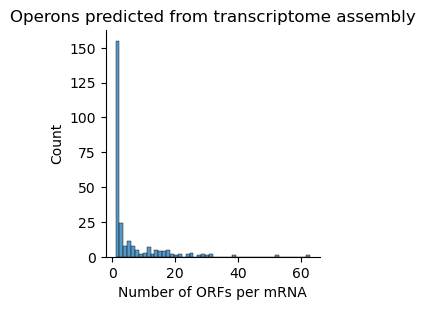

In [1]:
from riboss.orfs import operon_finder
import pyranges as pr
import pandas as pd

bed = '/home/limch05p/lim_group/riboss/ref/NC_003197.1.bed'
outdir = 'results'
tx_assembly='/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.fa'
delim = '::'

cds_range, cds_range_file, df = operon_finder(tx_assembly, bed, outdir, delim)
df.value_counts('ORF_type')

#### Analyse ribosome footprints

downsampling BAM       : 4990458it [00:06, 735376.09it/s]
comparing periodicity  : 100%|██████████████████████████████████████████████████| 11.0/11.0 [00:02<00:00, 4.03it/s]
INFO:root:saved selected footprint sizes with an offset as results/ERR9130942Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as results/ERR9130942Aligned.out.frames.pdf
INFO:root:saved metagene plots as results/ERR9130942Aligned.out.start_codon.pdf and results/ERR9130942Aligned.out.stop_codon.pdf
downsampling BAM       : 13110672it [00:16, 773139.26it/s]
comparing periodicity  : 100%|██████████████████████████████████████████████████| 11.0/11.0 [00:06<00:00, 1.61it/s]
INFO:root:saved selected footprint sizes with an offset as results/ERR9130943Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as results/ERR9130943Aligned.out.frames.pdf
INFO:root:saved metagene plots as results/ERR9130943Aligned.out.start_codon.pdf and results/ERR9130943Aligned.out.stop_codon.pdf
downsampl

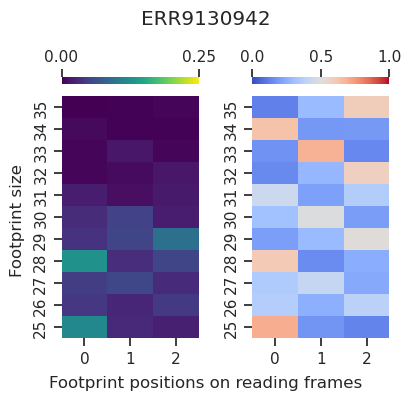

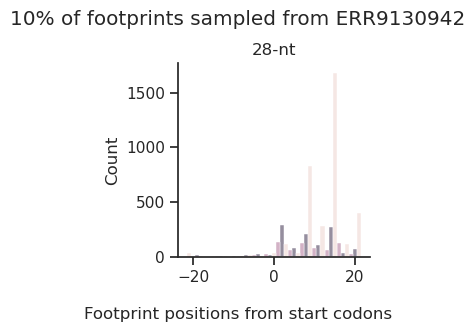

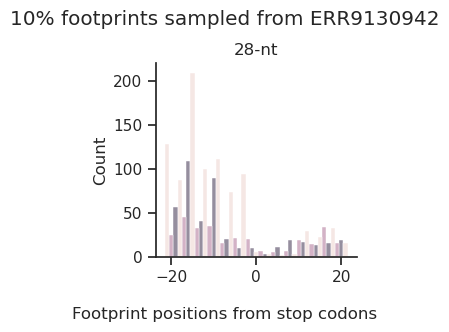

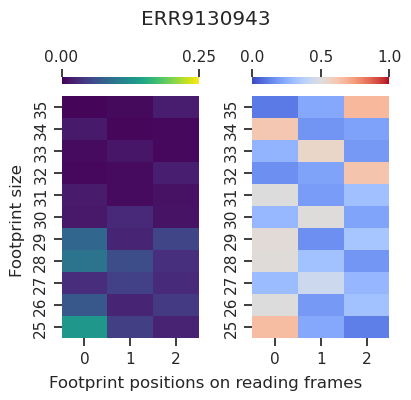

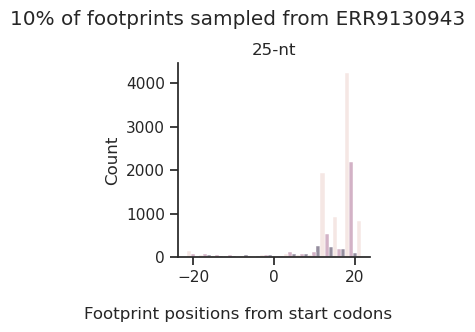

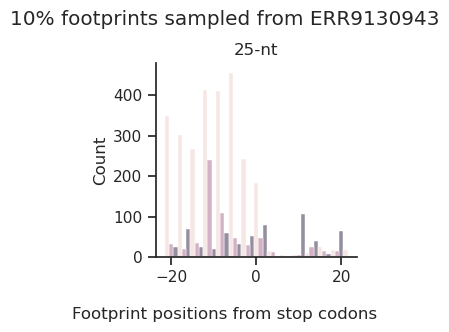

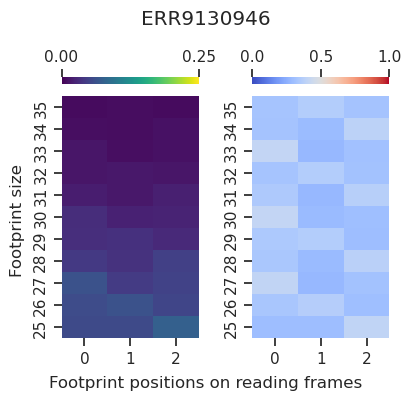

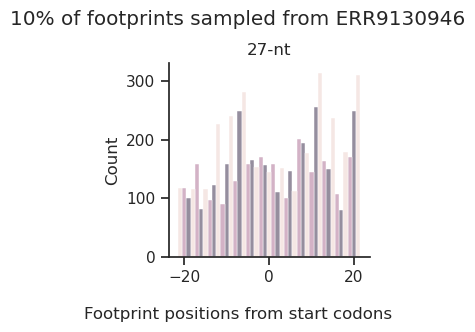

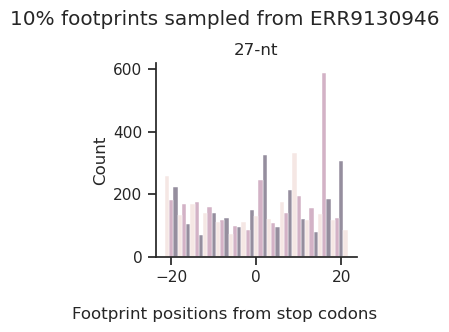

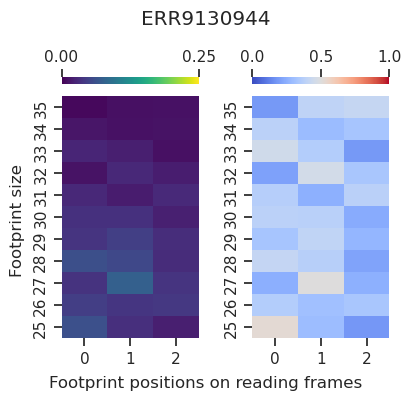

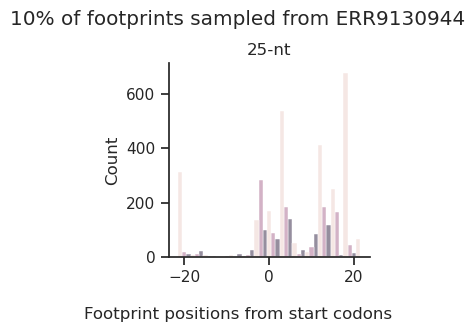

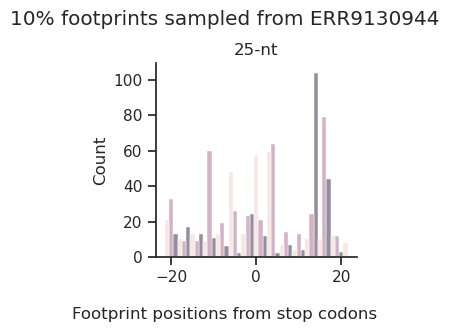

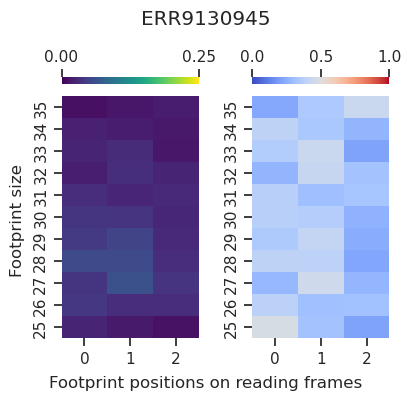

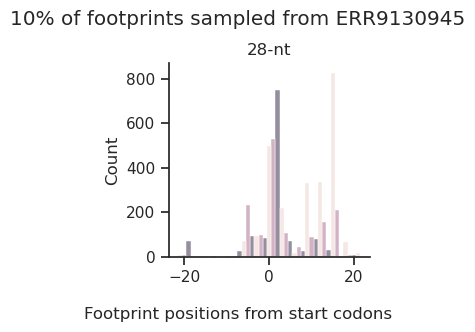

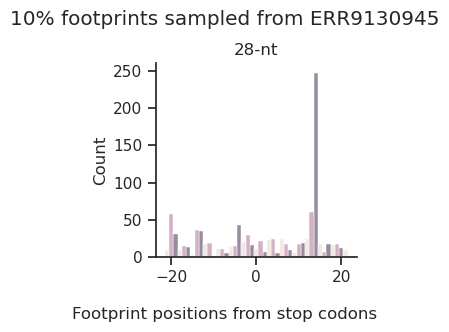

In [2]:
from riboss.footprints import analyse_footprints
from glob import glob
downsampling = 0.1

footprint_stats = []
for i in glob('/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/*Aligned.out.bam'):
    stats = analyse_footprints('Bacteria', i, downsampling, cds_range, 'best', outdir)
    footprint_stats.append(stats)

In [3]:
import pandas as pd

filereport = pd.read_csv('/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/filereport_read_run_PRJEB51486_tsv.txt', sep='\t')
filereport[['run_accession','sample_title']]

,run_accession,sample_title
0,ERR9130944,RiboSeq S7 1000U
1,ERR9130945,RiboSeq S7 750U
2,ERR9130942,RiboSeq RNase1 1000U
3,ERR9130943,RiboSeq RNase1 500U
4,ERR9130946,RNA-Seq


#### Build salmon index using transcriptome assembly and run salmon quant

In [4]:
from riboss.wrapper import count_reads

index = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750'
tx_assembly = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.fa'
rnaseq = '/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946.trimmed.fastq.gz'

count_reads(rnaseq, tx_assembly, index)

Version Info: This is the most recent version of salmon.
index ["/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750_pufferfish_idx/"] did not previously exist  . . . creating it
[2024-10-10 16:51:05.543] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2024-10-10 16:51:05.543] [jLog] [info] building index
out : /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750_pufferfish_idx/
[2024-10-10 16:51:05.550] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers

[2024-10-10 16:51:05.599] [puff::index::jointLog] [info] Replaced 0 non-ATCG nucleotides
[2024-10-10 16:51:05.599] [puff::index::jointLog] [info] Clipped poly-

Threads = 2
Vertex length = 31
Hash functions = 5
Filter size = 33554432
Capacity = 2
Files: 
/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750_pufferfish_idx/ref_k31_fixed.fa
--------------------------------------------------------------------------------
Round 0, 0:33554432
Pass	Filling	Filtering
1	0	1	
2	0	0
True junctions count = 155
False junctions count = 2756
Hash table size = 2911
Candidate marks count = 3220
--------------------------------------------------------------------------------
Reallocating bifurcations time: 0
True marks count: 918
Edges construction time: 0
--------------------------------------------------------------------------------
Distinct junctions = 155



TwoPaCo::buildGraphMain:: allocated with scalable_malloc; freeing.
TwoPaCo::buildGraphMain:: Calling scalable_allocation_command(TBBMALLOC_CLEAN_ALL_BUFFERS, 0);
allowedIn: 59
Max Junction ID: 697
seen.size():5585 kmerInfo.size():698
approximateContigTotalLength: 1257965
counters for complex kmers:
(prec>1 & succ>1)=15 | (succ>1 & isStart)=1 | (prec>1 & isEnd)=0 | (isStart & isEnd)=0
contig count: 483 element count: 1412294 complex nodes: 16
# of ones in rank vector: 482
[2024-10-10 16:51:06.183] [puff::index::jointLog] [info] Starting the Pufferfish indexing by reading the GFA binary file.
[2024-10-10 16:51:06.183] [puff::index::jointLog] [info] Setting the index/BinaryGfa directory /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750_pufferfish_idx
size = 1412294
-----------------------------------------
| Loading contigs | Time = 1.5353 ms
-----------------------------------------
size = 1412294
-----------------------------------------
| Loading contig boundari

for info, total work write each  : 2.331    total work inram from level 3 : 4.322  total work raw : 25.000 
Bitarray         7330112  bits (100.00 %)   (array + ranks )
final hash             0  bits (0.00 %) (nb in final hash 0)


-----------------------------------------
| Loading contig table | Time = 607.39 us
-----------------------------------------
size = 483
-----------------------------------------
| Loading contig offsets | Time = 822.54 us
-----------------------------------------
-----------------------------------------
| Loading reference lengths | Time = 6.963 us
-----------------------------------------
-----------------------------------------
| Loading mphf table | Time = 1.2765 ms
-----------------------------------------
size = 1412294
Number of ones: 482
Number of ones per inventory item: 512
Inventory entries filled: 1
-----------------------------------------
| Loading contig boundaries | Time = 2.6582 ms
-----------------------------------------
size = 1412294
-----------------------------------------
| Loading sequence | Time = 1.0949 ms
-----------------------------------------
size = 1397834
-----------------------------------------
| Loading positions | Time = 6.6424 ms
---------------

#### Run riboprof (ribomap)

In [5]:
from riboss.wrapper import riboprof

superkingdom='Bacteria'
ribobam = '/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130942Aligned.out.bam'
mrnabam = '/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946Aligned.out.bam'
tx_assembly = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.fa'
sf = '/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946_salmon_quant/quant.sf'
out = '/home/limch05p/lim_group/riboss/results/ERR9130942'
cds_range_file = '/home/limch05p/lim_group/riboss/results/D23005-sc-1962750.sorted.transcripts.cds_range.txt'

riboprof_base = riboprof(superkingdom, ribobam, mrnabam, tx_assembly, cds_range_file, sf, out)

getting transcript info...
total number of transcripts in transcriptome: 269
assigning ribo-seq reads...
constructing profile class...
number of transcripts in profile class: 259
loading reads from bam...
getting alignment records...
total number of reads: 195823
getting read type and p-sites...
total output footprint: 195823
total: 195823	multi_mapped: 425 (0.22 %)
assigning reads to frame 0 loci...
reads used: 36620 reads assigned: 36620
total input count not matching total assigning count!
assigning reads to frame 1 and 2 loci...
reads used: 104897 reads assigned: 104897
total input count not matching total assigning count!
assigning reads to UTR loci...
reads used: 195823 reads assigned: 195823
total input count not matching total assigning count!
assigning RNA-seq reads...
number of transcripts in profile class: 259
loading reads from bam...
getting alignment records...
total number of reads: 12613365
getting read type and p-sites...
total output footprint: 12613365
total: 1261336

INFO:root:saved main output as /home/limch05p/lim_group/riboss/results/ERR9130942.base


parsing ribomap output : 100%|███████████████████████████████████████████████████| 253/253 [00:00<00:00, 2.57kit/s]
counting footprints    : 100%|████████████████████████████████████████████████| 60.4k/60.4k [00:00<00:00, 119kit/s]
comparing periodicity  : 100%|████████████████████████████████████████████████| 2.34k/2.34k [03:06<00:00, 12.6it/s]
INFO:root:saved RIBOSS stats as results/ERR9130942.riboss.csv and results/ERR9130942.riboss.json
INFO:root:saved significant RIBOSS results (n=52) as results/ERR9130942.riboss.sig.csv, results/ERR9130942.riboss.sig.json, and results/ERR9130942.riboss.sig.bed
INFO:root:perform BLASTP for RIBOSS hits (n=52)
INFO:root:finished BLASTP in 1 min 3 s
INFO:root:saved BLASTP results for RIBOSS hits as results/ERR9130942.riboss.sig.blastp.xml
INFO:root:efetching IPG for CQH27524
/projects/health_sciences/bms/biochemistry/lim_group/cslim/anaconda3/lib/python3.12/site-packages/Bio/Entrez/__init__.py:658: UserWarning: 
Email address is not specified.

To ma

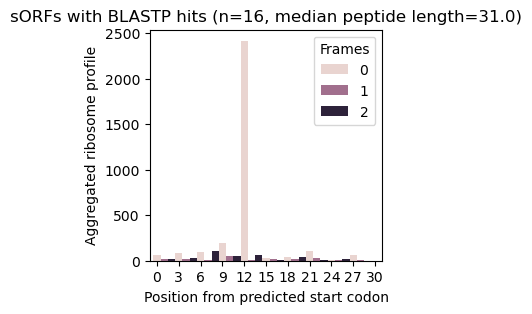

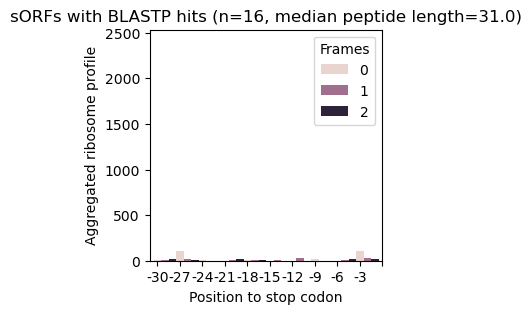

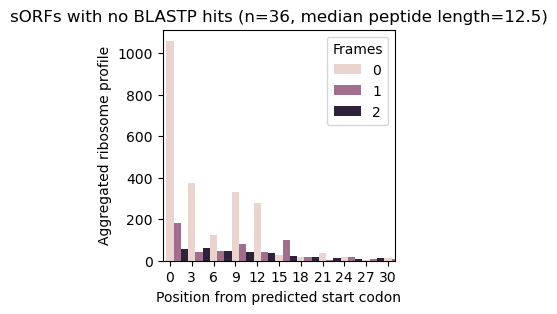

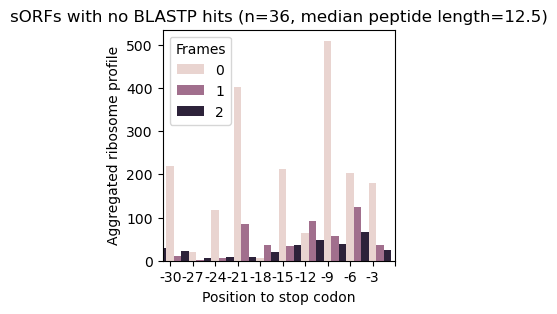

In [6]:
from riboss.riboss import riboss

riboprof_base = '/home/limch05p/lim_group/riboss/results/ERR9130942.base'
superkingdom='Bacteria'

ipg, tophits, blast, sig, boss_df = riboss(superkingdom, df, riboprof_base, tx_assembly, 
                                           tie=False, num_simulations=1000, 
                                           run_blastp=True, run_efetch=True, tries=5, sleep=2, 
                                           email=None, api_key=None, 
                                           outdir=outdir)

In [7]:
tophits.dropna().title.str.split(r'\| ').str[1].str.split(r' \[').str[0].unique()

array(['GTP-binding protein', 'hypothetical protein, partial',
       'hypothetical protein', 'glucosamine-6-phosphate isomerase',
       'GroEL protein', 'elongation factor G',
       '30S ribosomal protein S13', 'lysyl-tRNA synthetase',
       'cytidylate kinase', '30S ribosomal protein S4',
       'chaperonin GroEL', 'elongation factor P',
       'hypothetical protein D0Z08_31505', '3-oxoacyl-ACP synthase',
       'ATP synthase subunit alpha'], dtype=object)

In [21]:
import numpy as np

np.median(tophits[pd.isnull(tophits).any(axis=1)].aa.apply(len)), np.median(tophits[~pd.isnull(tophits).any(axis=1)].aa.apply(len))

(12.5, 31.0)

In [23]:
np.median(tophits[pd.isnull(tophits).any(axis=1)].fa.apply(len)), np.median(tophits[~pd.isnull(tophits).any(axis=1)].fa.apply(len))

(84.0, 104.0)

In [ ]:
np.median(blastp_hits.aa.apply(len))

In [22]:
tophits[pd.isnull(tophits).any(axis=1)].shape, tophits[~pd.isnull(tophits).any(axis=1)].shape

((36, 24), (16, 24))